Imports needen only in Colab

In [0]:
#!pip install -q tensorflow-gpu==2.0.0-beta0

#import os
# from google.colab import drive
# drive.mount('/content/drive/')
# try:
# os.chdir("drive/My Drive/snr/project")
# except FileNotFoundError:
#     pass
#!git clone https://gitlab.com/0darnox0/snr.git
#os.chdir("/content/snr")

All other imports

In [0]:
import os

import tensorflow as tf
from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from definitions import *
from preprocessing import load_datasets, time_footprint, load_labels_datasets

# Load datasets

In [3]:
train_ds, test_ds, val_ds = load_datasets()

W0611 00:06:33.502883 140042173867904 deprecation.py:323] From /content/snr/preprocessing.py:56: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


# Create model no. 1 (learning rate = 1e-4)

In [0]:
ALPHA = 1.0  # controls the width of the network
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False, 
                                               alpha       = ALPHA,
                                               weights     = 'imagenet')

In [0]:
base_model.trainable = False

In [0]:
model1 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 1.0e-4
model1.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________


# Test model no. 1

In [9]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_1_2019-06-09_23-40-28'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model1.load_weights(latest)
model1.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss, acc = model1.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model1.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate = [0 for i in range(0,106)]
real_crc_rate[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate[i] = real_crc_rate[i-1] + cmc_rate[i]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________
106/106 [==============================] - 35s 332ms/step - loss: 1.2989 - accuracy: 0.6879
    120/Unknown - 35s 294ms/step

#Display evaluation for model no. 1


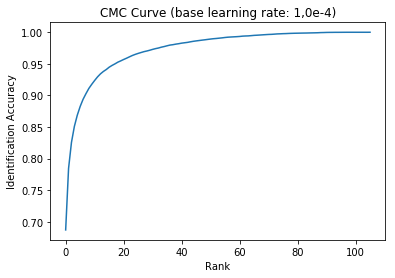


Restored model, accuracy: 68.79%

TOP1 error rate: 31.29%

TOP5 error rate: 13.14%


In [20]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve (base learning rate: 1,0e-4)')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate[4])))

# Create model no. 2 (learning rate = 2.5e-5)

In [0]:
model2 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
model2.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [12]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________


# Test model no. 2

In [13]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_1_2019-06-10_16-59-57'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model2.load_weights(latest)
model2.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss2, acc2 = model2.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model2.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate2 = [0 for i in range(0,106)]
real_crc_rate2[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate2[i] = real_crc_rate2[i-1] + cmc_rate[i]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________
106/106 [==============================] - 31s 288ms/step - loss: 1.3102 - accuracy: 0.6872
    120/Unknown - 34s 286ms/step

#Display evaluation for model no. 2

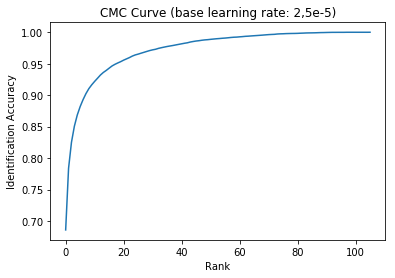


Restored model, accuracy: 68.72%

TOP1 error rate: 31.42%

TOP5 error rate: 13.16%


In [21]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate2)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve (base learning rate: 2,5e-5)')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc2))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2[4])))

#Comparison of models

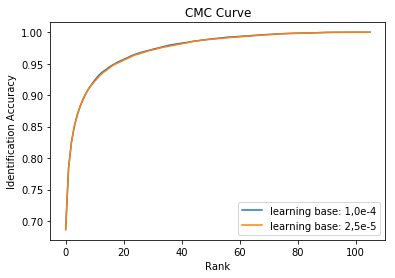

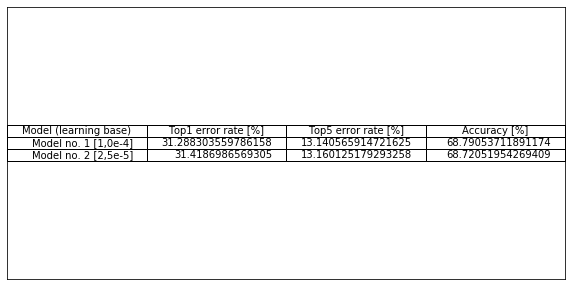

In [19]:
plt.plot(real_crc_rate, label='base learning rate: 1,0e-4')
plt.plot(real_crc_rate2, label='base learning rate: 2,5e-5')
plt.legend(loc='best')
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve')
plt.show()



fig=plt.figure(figsize=[10,5])

ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
colLabels=("Model (base learning rate)", "Top1 error rate [%]", "Top5 error rate [%]", "Accuracy [%]")
the_table = ax.table(cellText=[
    ["Model no. 1 [1,0e-4]",100*(1.0 - real_crc_rate[0]),100*(1.0 - real_crc_rate[4]), acc*100],
    ["Model no. 2 [2,5e-5]",100*(1.0 - real_crc_rate2[0]),100*(1.0 - real_crc_rate2[4]), acc2*100]],
          colLabels=colLabels,
          loc='center')


